In [1]:
import os
import sys
import gc
import tarfile
import h5py
import shelve

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import LocallyConnected2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

from keras.utils import np_utils
from keras.optimizers import SGD

from scipy.ndimage import imread
from scipy.misc import imresize

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [1]:
tf.__version__

NameError: name 'tf' is not defined

In [5]:
imread(os.path.join('train', '5.png')).shape

(68, 140, 3)

# Download SVHN Dataset

In [2]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent

    
url = "http://ufldl.stanford.edu/housenumbers/"

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename



In [3]:
train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)

('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


# Extract Files

In [4]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    return None
  
maybe_extract(train_filename)
maybe_extract(test_filename)
maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.
extra already present - Skipping extraction of extra.tar.gz.


# Preprocess Data in Tidy Format from .mat file

In [5]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [6]:
fin_train = os.path.join(train_filename.split('.')[0], 'digitStruct.mat')
fin_test = os.path.join(test_filename.split('.')[0], 'digitStruct.mat')

train_data = DigitStructFile(fin_train).getAllDigitStructure_ByDigit()
test_data = DigitStructFile(fin_test).getAllDigitStructure_ByDigit()

# Process photo following methodology as per Google Paper

In [161]:
def get_X_y(data, folder='train'):
    X = np.zeros((len(data), 54**2 * 3))
    y = []
    top_right_bottom_left = np.zeros((len(data), 4))
    for i in xrange(len(data)):
        boxes = data[i]['boxes']
        num_digits = len(boxes)
        label = np.zeros(num_digits)
        side_vals = []
        
        
        for digit in range(num_digits):
            side_vals.append((boxes[digit]['left'], boxes[digit]['top'],
                              boxes[digit]['width'],boxes[digit]['height']))          
            if boxes[digit]['label'] == 10:
                label[digit] = 0
            else:
                label[digit] = boxes[digit]['label']
        side_vals.sort()

        left = int(side_vals[0][0])
        right = int(side_vals[-1][0] + side_vals[-1][2]) 
        top = int(min([val[1] for val in side_vals]))
        height = int(max([val[-1] for val in side_vals]))
        bottom = top + height
        width = right - left

        x_buffer = int((width * 0.3) /  2)
        y_buffer = int((height * 0.3) /  2)

        top_buffer = top - y_buffer if (top - y_buffer) >= 0 else 0
        left_buffer = left - x_buffer if (left - x_buffer) >= 0 else 0
        bottom_buffer = bottom + y_buffer
        right_buffer = right + x_buffer

        top_buffer = top - y_buffer if (top - y_buffer) >= 0 else 0
        top_buffer = top - y_buffer if (top - y_buffer) >= 0 else 0

        image = imread(os.path.join(folder, data[i]['filename']))

        rectangle = image[top_buffer:bottom_buffer, 
                          left_buffer:right_buffer, :]

        resized = imresize(rectangle, (64, 64))

        shift_x = np.random.randint(10)
        shift_y = np.random.randint(10)

        cropped = resized[shift_y:(shift_y + 54), shift_x:(shift_x + 54), :]

        X[i] = cropped.ravel()
        y.append(np_utils.to_categorical(label, 11))
        top_right_bottom_left[i] = top, right, bottom, left

    return X, y, top_right_bottom_left

In [162]:
def get_data():
    X_train, y_train, trbl_train = get_X_y(train_data, folder='train')
    X_test, y_test, trbl_test = get_X_y(test_data, folder='test')  
    return X_train, y_train, trbl_train, X_test, y_test, trbl_test

In [163]:
X_train, y_train, trbl_train, X_test, y_test, trbl_test = get_data()

# Plot few pictures and make sure labels line up with them

In [164]:
idx_train = np.random.choice(np.arange(X_train.shape[0]), size=9, replace=False)
idx_test = np.random.choice(np.arange(X_test.shape[0]), size=9, replace=False)

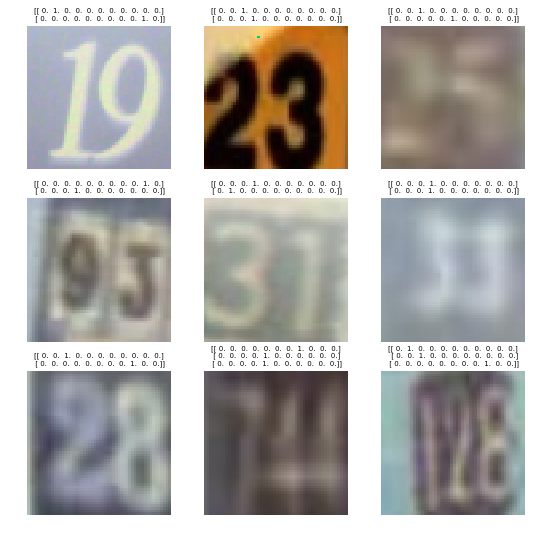

In [165]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in zip(np.arange(9), axes.ravel()):
    ax.imshow(X_train[i].reshape((54, 54, 3)))
    ax.set_title(y_train[i], fontsize=7)
    ax.set_axis_off()

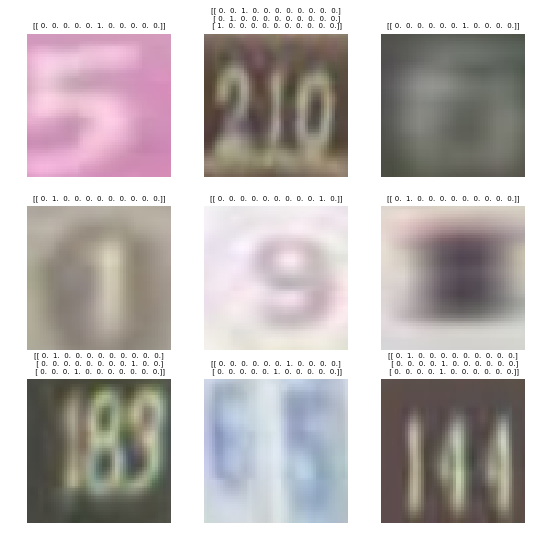

In [166]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in zip(np.arange(9), axes.ravel()):
    ax.imshow(X_test[i].reshape((54, 54, 3)))
    ax.set_title(y_test[i], fontsize=7)
    ax.set_axis_off()

# Add length of digits along with box border data

In [167]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [168]:
length_number_train = np.array(map(len, y_train))
length_number_test = np.array(map(len, y_test))

#there's one pic with 6 digits
idx_6 = np.argmax(length_number_train)

print('index with the 6th digit is: ', idx_6)

length_number_train = np.delete(length_number_train, idx_6)

# make sure that there was only one 6 digit point
assert np.max(length_number_train) == 5

# make sure to delete 6th digit data point
# We'll insure that the data lines up 
# by plotting some photos with labels
# after the deleted point
X_train = np.delete(X_train, idx_6, axis=0)
y_train = np.delete(y_train, idx_6)
trbl_train = np.delete(trbl_train, idx_6, axis=0)


assert X_train.shape[0] == len(y_train)
assert len(y_train) == len(length_number_train)
assert X_train.shape[0] == trbl_train.shape[0]


print('maximum digits in train = ', np.max(length_number_train))
print('maximum digits in test = ', np.max(length_number_test))

# We'll reduce by one to ensure that they start on a 
# 0-4 scale
length_number_train -= 1
length_number_test -= 1

('index with the 6th digit is: ', 29929)
('maximum digits in train = ', 5)
('maximum digits in test = ', 5)


# Plot photos again to ensure labels line up with photos since we took out an outlier

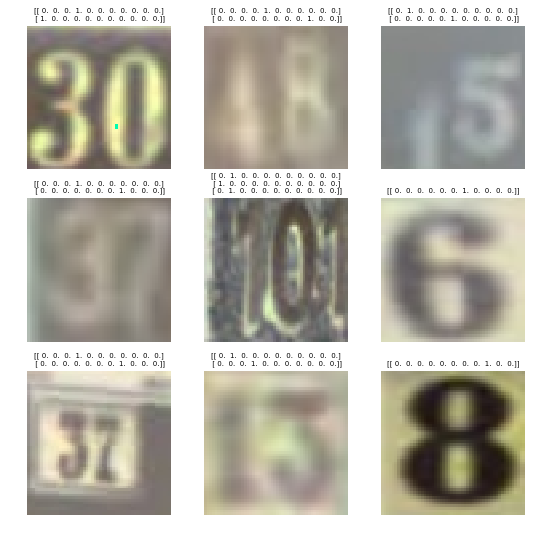

In [169]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in zip(np.arange(9), axes.ravel()):
    ax.imshow(X_train[idx_6 + i].reshape((54, 54, 3)))
    ax.set_title(y_train[idx_6 + i], fontsize=7)
    ax.set_axis_off()

# Normalize data to ensure all labels are in a 5x11 matrix regardless of number of digits.  Missing Digits will be expressd as a row of ten zeros

In [170]:
# convert to one hot encoding
length_vector_train = map(lambda x: np_utils.to_categorical(x, 5), length_number_train)
length_vector_test = map(lambda x: np_utils.to_categorical(x, 5), length_number_test)

In [185]:
space_array = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

for i in range(len(length_number_train)):
    y_train[i] = np.r_[y_train[i], np.tile(space_array, (4 - length_number_train[i], 1))]
    
for i in range(len(length_number_test)):
    y_test[i] = np.r_[y_test[i], np.tile(space_array, (4 - length_number_test[i], 1))]


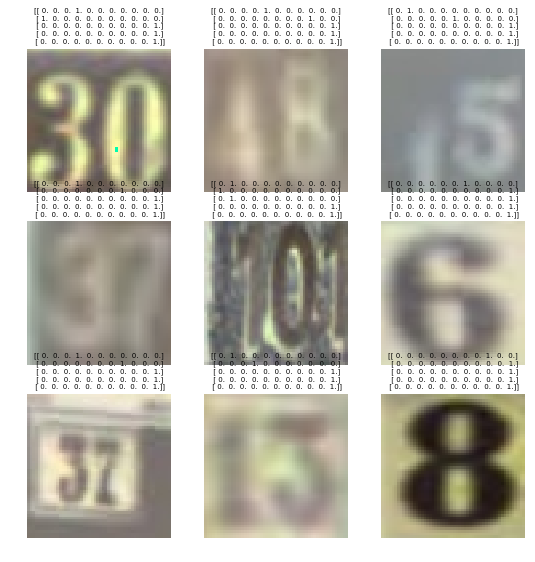

In [186]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in zip(np.arange(9), axes.ravel()):
    ax.imshow(X_train[idx_6 + i].reshape((54, 54, 3)))
    ax.set_title(y_train[idx_6 + i], fontsize=7)
    ax.set_axis_off()

# Create training, validation and test sets

In [187]:
validation_idx = int(0.75 * X_train.shape[0])

X_validation = X_train[validation_idx:]
y_validation = y_train[validation_idx:]
length_validation = np.concatenate(length_vector_train[validation_idx:])
trbl_validation = trbl_train[validation_idx:]

X_train = X_train[:validation_idx]
y_train = y_train[:validation_idx]
length_train = np.concatenate(length_vector_train[:validation_idx])
trbl_train = trbl_train[:validation_idx]

length_test = np.concatenate(length_vector_test)
y_train = np.array(y_train)

# Save preprocessed data into hdf5 format for later use

In [188]:
with h5py.File("SVHN.hdf5", "w") as f:

    f["X_train"] = X_train
    f["X_validation"] = X_validation
    f["X_test"] = X_test

    f["y_train"] = y_train.tolist()
    f["y_validation"] = y_validation.tolist()
    f["y_test"] = y_test.tolist()

    f["length_train"] = length_train
    f["length_validation"] = length_validation
    f["length_test"] = length_test

    f["trbl_train"] = trbl_train
    f["trbl_validation"] = trbl_validation
    f["trbl_test"] = trbl_test



In [189]:
with h5py.File("SVHN.hdf5", "r") as f:
    print f["X_train"].shape


(25050, 8748)


In [190]:
break

SyntaxError: 'break' outside loop (<ipython-input-190-b20fcc2397e7>, line 1)

<br> <br> <br>

# Set up data and labels to be fed into keras model fit

In [18]:
X_train = X_train.reshape((X_train.shape[0], 54, 54, 3))
X_validation = X_validation.reshape((X_validation.shape[0], 54, 54, 3))
X_test = X_test.reshape((X_test.shape[0], 54, 54, 3))

Digit_1_train = np.concatenate(y_train)[0::5]
Digit_2_train = np.concatenate(y_train)[1::5]
Digit_3_train = np.concatenate(y_train)[2::5]
Digit_4_train = np.concatenate(y_train)[3::5]
Digit_5_train = np.concatenate(y_train)[4::5]

Digit_1_validation = np.concatenate(y_validation)[0::5]
Digit_2_validation = np.concatenate(y_validation)[1::5]
Digit_3_validation = np.concatenate(y_validation)[2::5]
Digit_4_validation = np.concatenate(y_validation)[3::5]
Digit_5_validation = np.concatenate(y_validation)[4::5]

Digit_1_test = np.concatenate(y_test)[0::5]
Digit_2_test = np.concatenate(y_test)[1::5]
Digit_3_test = np.concatenate(y_test)[2::5]
Digit_4_test = np.concatenate(y_test)[3::5]
Digit_5_test = np.concatenate(y_test)[4::5]

top_train = trbl_train[:, 0]
right_train = trbl_train[:, 1]
bottom_train = trbl_train[:, 2]
left_train = trbl_train[:, 3]

top_validation = trbl_validation[:, 0]
right_validation = trbl_validation[:, 1]
bottom_validation = trbl_validation[:, 2]
left_validation = trbl_validation[:, 3]

top_test = trbl_test[:, 0]
right_test = trbl_test[:, 1]
bottom_test = trbl_test[:, 2]
left_test = trbl_test[:, 3]

In [75]:
top_train.shape

(25050,)

In [74]:
top_train

array([ 5.54420801,  1.26181883, -0.38525394, ...,  0.43828245,
        0.10886789, -0.22054666])

In [73]:
scaler = StandardScaler()

top_train = scaler.fit_transform(top_train)
right_train = scaler.fit_transform(right_train)
bottom_train = scaler.fit_transform(bottom_train)
left_train = scaler.fit_transform(left_train)

top_validation = scaler.fit_transform(top_validation)
right_validation = scaler.fit_transform(right_validation)
bottom_validation = scaler.fit_transform(bottom_validation)
left_validation = scaler.fit_transform(left_validation)

top_test = scaler.fit_transform(top_test)
right_test = scaler.fit_transform(right_test)
bottom_test = scaler.fit_transform(bottom_test)
left_test = scaler.fit_transform(left_test)

/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X

In [76]:
y_train_list = [Digit_1_train, 
                Digit_2_train, 
                Digit_3_train, 
                Digit_4_train, 
                Digit_5_train, 
                length_train,
                top_train,
                right_train,
                bottom_train,
                left_train]

y_validation_list = [Digit_1_validation, 
                     Digit_2_validation, 
                     Digit_3_validation, 
                     Digit_4_validation, 
                     Digit_5_validation, 
                     length_validation, 
                     top_validation,
                     right_validation,
                     bottom_validation,
                     left_validation]

y_test_list = [Digit_1_test, 
               Digit_2_test, 
               Digit_3_test, 
               Digit_4_test, 
               Digit_5_test, 
               length_train,
               top_test,
               right_test,
               bottom_test,
               left_test]

# Create model

In [77]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

In [79]:
def larger_model():    
    model_input = Input(shape=(54, 54, 3))

    x = (Convolution2D(48, 5, 5, border_mode='same'))(model_input)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))(x)

    x = (Convolution2D(64, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(128, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(160, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(192, 3, 3, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(192, 3, 3, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(192, 3, 3, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))(x)
    x = (Dropout(0.25))(x)

    x = (Convolution2D(192, 3, 3, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)
    x = (Dropout(0.25))(x)

    x = Dense(3072, activation='relu')(x)
    x = Dropout(0.25)(x)    

    split_point = Flatten()(x)  



    x = Dense(1024, activation='relu')(split_point)
    conv_out = Dropout(0.25)(x)


    Digit_1 =  Dense(10, activation='softmax', name='Digit_1')(conv_out)
    Digit_2 =  Dense(10, activation='softmax', name='Digit_2')(conv_out)
    Digit_3 =  Dense(10, activation='softmax', name='Digit_3')(conv_out)
    Digit_4 =  Dense(10, activation='softmax', name='Digit_4')(conv_out)
    Digit_5 =  Dense(10, activation='softmax', name='Digit_5')(conv_out)

    length =  Dense(5, activation='softmax', name='length')(conv_out)

    #################################################################################
    y = Dense(1024, activation='relu')(split_point)
    y = Dropout(0.25)(y)

    y = Dense(512, activation='relu')(y)
    conv_out2 = Dropout(0.25)(y)

    top_var =  Dense(1, init='normal', activation='relu', name='top')(conv_out2)
    right_var =  Dense(1, init='normal', activation='relu', name='right')(conv_out2)
    bottom_var =  Dense(1, init='normal', activation='relu', name='bottom')(conv_out2)
    left_var =  Dense(1, init='normal', activation='relu', name='left')(conv_out2)
    ##################################################################################

    combined = [Digit_1, Digit_2, Digit_3, Digit_4, Digit_5, length, top_var, right_var, bottom_var, left_var]

    model = Model(input=model_input, output=combined)

    #     sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss={'Digit_1':'categorical_crossentropy',
                        'Digit_2':'categorical_crossentropy',
                        'Digit_3':'categorical_crossentropy',
                        'Digit_4':'categorical_crossentropy',
                        'Digit_5':'categorical_crossentropy',
                        'length':'categorical_crossentropy',
                        'top':'mean_squared_error',
                        'right':'mean_squared_error',
                        'bottom':'mean_squared_error',
                        'left':'mean_squared_error'}, 
                         optimizer='adadelta', 
                  metrics={ 'Digit_1':'categorical_accuracy',
                            'Digit_2':'categorical_accuracy',
                            'Digit_3':'categorical_accuracy',
                            'Digit_4':'categorical_crossentropy',
                            'Digit_5':'categorical_crossentropy',
                            'length':'categorical_crossentropy',
                            'top':'mean_squared_error',
                            'right':'mean_squared_error',
                            'bottom':'mean_squared_error',
                            'left':'mean_squared_error'})
    return model

# Fit model

In [80]:
# # build the model
model = larger_model()
# # Fit the model
model.fit(X_train, y_train_list,
          validation_data=(X_validation, y_validation_list), nb_epoch=10, batch_size=200, verbose=2)

Train on 25050 samples, validate on 8351 samples
Epoch 1/10
8341s - loss: 43.9135 - Digit_1_loss: 11.7958 - Digit_2_loss: 12.1533 - Digit_3_loss: 4.3847 - Digit_4_loss: 0.6231 - Digit_5_loss: 0.0036 - length_loss: 7.4404 - top_loss: 1.5975 - right_loss: 3.0062 - bottom_loss: 1.6458 - left_loss: 1.2631 - Digit_1_categorical_accuracy: 0.2669 - Digit_1_mean_squared_error: 0.1465 - Digit_2_categorical_accuracy: 0.0884 - Digit_2_mean_squared_error: 0.1665 - Digit_3_categorical_accuracy: 0.0327 - Digit_3_mean_squared_error: 0.1240 - Digit_4_categorical_accuracy: 0.0410 - Digit_4_mean_squared_error: 0.1033 - Digit_5_categorical_accuracy: 0.6363 - Digit_5_mean_squared_error: 0.0995 - length_categorical_accuracy: 0.5371 - length_mean_squared_error: 0.1850 - top_categorical_accuracy: 1.0000 - top_mean_squared_error: 1.5975 - right_categorical_accuracy: 1.0000 - right_mean_squared_error: 3.0062 - bottom_categorical_accuracy: 1.0000 - bottom_mean_squared_error: 1.6458 - left_categorical_accuracy: 

In [81]:
# # # Final evaluation of the model
scores = model.evaluate(X_test, {'Digit_1':Digit_1_test,
                                 'Digit_2':Digit_2_test,
                                 'Digit_3':Digit_3_test,
                                 'Digit_4':Digit_4_test,
                                 'Digit_5':Digit_5_test,
                                 'length':length_test,
                                 'top':top_test,
                                 'right':right_test,
                                 'bottom':bottom_test,
                                 'left':left_test}, verbose=0)

In [82]:
scores

[35.783532518912864,
 11.5619089504904,
 11.788854913387526,
 2.4507694829666984,
 0.16774265188524254,
 0.0024668037033898408,
 5.8117895505827502,
 0.99999999823028751,
 1.0000000034664471,
 1.0000000026363243,
 1.0000000086843621,
 0.28267523721156956,
 0.14346495212574856,
 0.078588919502571519,
 0.16528160431752117,
 0.018518518518518517,
 0.1133532291081545,
 0.00091827364554637281,
 0.10094888365100858,
 0.0,
 0.10001530603627966,
 0.63942454850633534,
 0.14423018095049611,
 1.0,
 0.99999999823028751,
 1.0,
 1.0000000034664471,
 1.0,
 1.0000000026363243,
 1.0,
 1.0000000086843621]

In [90]:
model.predict(X_test[10000].reshape((1,54,54,3)))

[array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.]], dtype=float32),
 array([[ 0.]], dtype=float32),
 array([[ 0.]], dtype=float32),
 array([[ 0.]], dtype=float32)]

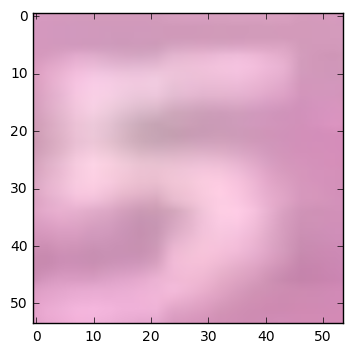

In [85]:
plt.imshow(X_test[0])